In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
CSV_PATH = "dataset_columns.csv"
IMG_DIR = "merged_images"
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_dataframe(csv_path):
    df = pd.read_csv(csv_path)
    df = df[['Image Index', 'Patient Age', 'Patient Gender']].dropna()
    df = df[df['Patient Age'].between(0, 100)]
    df['Age'] = df['Patient Age'].astype(float)
    df['Gender Label'] = df['Patient Gender'].map({'M': 0, 'F': 1})
    return df

df = prepare_dataframe(CSV_PATH)

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Gender Label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[ 'Gender Label'], random_state=42)


C:\Users\kiran\AppData\Local\Temp\ipykernel_12812\943343906.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='Patient Gender', palette='pastel')


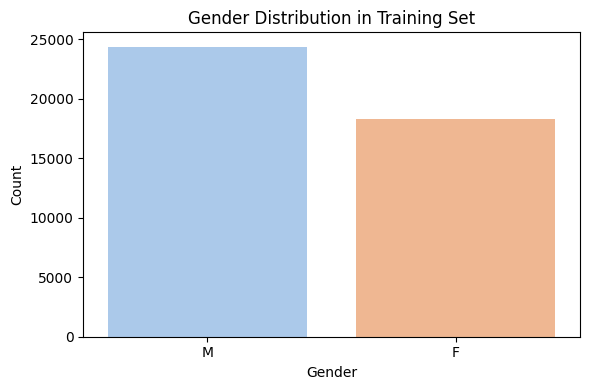

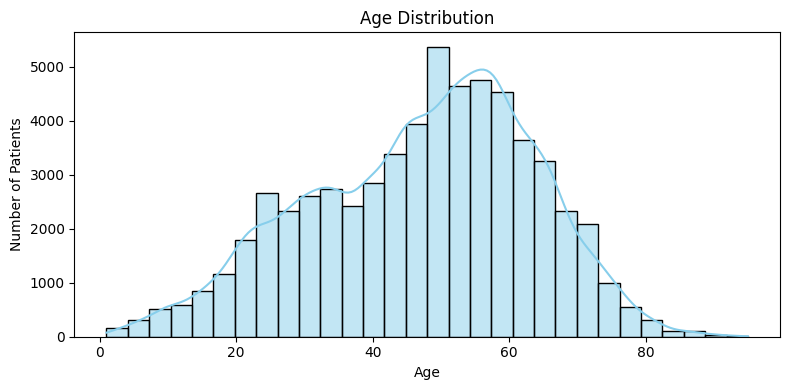

C:\Users\kiran\AppData\Local\Temp\ipykernel_12812\943343906.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Patient Gender', y='Age', palette='Set2')


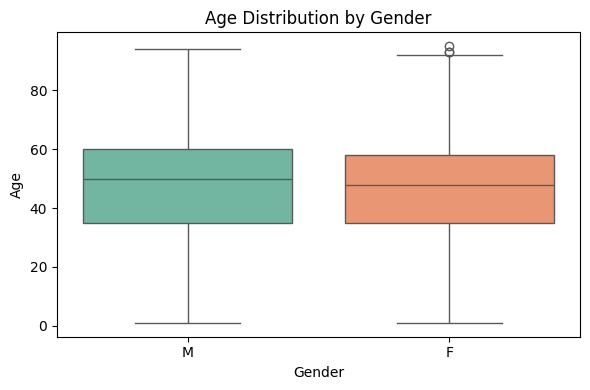

In [ ]:

plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='Patient Gender', palette='pastel')
plt.title("Gender Distribution in Training Set")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Patient Gender', y='Age', palette='Set2')
plt.title("Age Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

In [6]:
class AgeGenderDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.img_dir, row['Image Index'])
        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        age_label = int(row['Age'])
        gender_label = int(row['Gender Label'])
        return image, age_label, gender_label

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_loader = DataLoader(AgeGenderDataset(train_df, IMG_DIR, transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(AgeGenderDataset(val_df, IMG_DIR, transform), batch_size=BATCH_SIZE)
test_loader = DataLoader(AgeGenderDataset(test_df, IMG_DIR, transform), batch_size=BATCH_SIZE)


In [ ]:
class MultiOutputModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.age_head    = nn.Linear(in_features, 1) 
        self.gender_head = nn.Linear(in_features, 2)

    def forward(self, x):
        x = self.backbone(x)
        return self.age_head(x).squeeze(1), self.gender_head(x)


model = MultiOutputModel().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion_age = nn.MSELoss() 
criterion_gender = nn.CrossEntropyLoss()


C:\Users\kiran\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kiran\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss_age, total_loss_gender = 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, age_labels, gender_labels in loop:
        images = images.to(DEVICE)
        age_labels = age_labels.float().to(DEVICE)
        gender_labels = gender_labels.to(DEVICE)

        optimizer.zero_grad()

     
        age_preds, gender_preds = model(images)


        loss_age = criterion_age(age_preds, age_labels)
        loss_gender = criterion_gender(gender_preds, gender_labels)

       
        loss = loss_age + loss_gender
        loss.backward()
        optimizer.step()

    
        total_loss_age += loss_age.item()
        total_loss_gender += loss_gender.item()

    avg_age_loss    = total_loss_age    / len(train_loader)
    avg_gender_loss = total_loss_gender / len(train_loader)
    print(f"Epoch {epoch+1} | Age Loss: {avg_age_loss:.4f} | Gender Loss: {avg_gender_loss:.4f}")


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 667/667 [08:03<00:00,  1.38it/s]


Epoch 1 | Age Loss: 983.9367 | Gender Loss: 0.6836


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 667/667 [08:12<00:00,  1.35it/s]


Epoch 2 | Age Loss: 90.8672 | Gender Loss: 0.6755


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 667/667 [05:31<00:00,  2.01it/s]


Epoch 3 | Age Loss: 50.7687 | Gender Loss: 0.6516


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 667/667 [06:50<00:00,  1.63it/s]


Epoch 4 | Age Loss: 39.9603 | Gender Loss: 0.5857


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 667/667 [04:28<00:00,  2.48it/s]

Epoch 5 | Age Loss: 31.5443 | Gender Loss: 0.4096


Test Age Loss (MSE):       56.031
Test Gender Loss:          0.325
Age MAE:                   5.727
Age RMSE:                  7.485
Gender Accuracy:           0.870


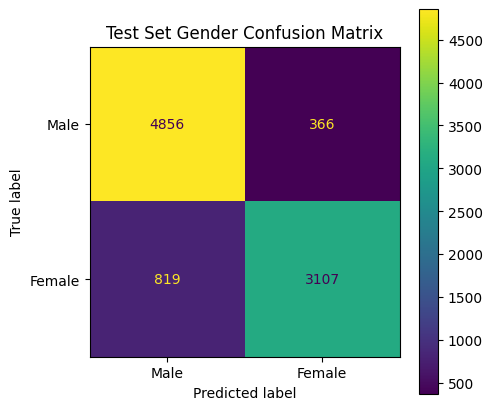

Gender Prediction Distribution:
  True:  [5222 3926]
  Pred:  [5675 3473]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, loader, criterion_age, criterion_gender, device):
    model.eval()
    running_age_loss, running_gender_loss = 0.0, 0.0
    total, total_age_mae, total_age_squared_error, correct_gender = 0, 0.0, 0.0, 0
    all_true_genders, all_pred_genders = [], []

    with torch.no_grad():
        for images, age_labels, gender_labels in loader:
            images        = images.to(device)
            age_labels    = age_labels.float().to(device)
            gender_labels = gender_labels.to(device)

            age_out, gender_out = model(images)
            loss_age    = criterion_age(age_out, age_labels)
            loss_gender = criterion_gender(gender_out, gender_labels)
            
            running_age_loss    += loss_age.item() * images.size(0)
            running_gender_loss += loss_gender.item() * images.size(0)
            age_errors = age_out.squeeze() - age_labels
            total_age_mae += torch.abs(age_errors).sum().item()
            total_age_squared_error += (age_errors ** 2).sum().item()

            
            preds_gender = gender_out.argmax(dim=1)
            correct_gender += (preds_gender == gender_labels).sum().item()
            all_true_genders.extend(gender_labels.cpu().numpy())
            all_pred_genders.extend(preds_gender.cpu().numpy())

            total += images.size(0)

    return {
        'age_loss'      : running_age_loss / total,
        'gender_loss'   : running_gender_loss / total,
        'age_mae'       : total_age_mae / total,
        'age_rmse'      : np.sqrt(total_age_squared_error / total),
        'gender_acc'    : correct_gender / total,
        'true_genders'  : np.array(all_true_genders),
        'pred_genders'  : np.array(all_pred_genders),
    }


test_metrics = evaluate_model(model, test_loader, criterion_age, criterion_gender, DEVICE)

# results
print(f"Test Age Loss (MSE):       {test_metrics['age_loss']:.3f}")
print(f"Test Gender Loss:          {test_metrics['gender_loss']:.3f}")
print(f"Age MAE:                   {test_metrics['age_mae']:.3f}")
print(f"Age RMSE:                  {test_metrics['age_rmse']:.3f}")
print(f"Gender Accuracy:           {test_metrics['gender_acc']:.3f}")


cm = confusion_matrix(test_metrics['true_genders'], test_metrics['pred_genders'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Male", "Female"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)
plt.title("Test Set Gender Confusion Matrix")
plt.show()


true_counts = np.bincount(test_metrics['true_genders'])
pred_counts = np.bincount(test_metrics['pred_genders'])
print("Gender Prediction Distribution:")
print("  True: ", true_counts)
print("  Pred: ", pred_counts)


In [14]:
torch.save(model.state_dict(), "age_gender.pth")
print(" Weights saved to age_gender.pth")

 Weights saved to age_gender.pth
